In [1]:
from __future__ import print_function
import ipywidgets as widgets 
import matplotlib.pyplot as plt
import numpy as np

# Non-Determinisitic Evaluation

### Mediator Parameters

$n$ : the number of times a jobs is executed for verification.

$PR \in [0,1] \subset \mathbb{R}$ : the penalty rate, used to determine the minimum deposit of both Job Creators and Resource Providers

$NDPR \in [0,1] \subset \mathbb{R}$ : the non-deterministic penalty rate, used to determine the Job Creators non-deterministic deposit

$baseFee = JCmediatorPrice + RPmediatorPrice$ : The fee the Mediator requires to be available for a mediation. A mediator can be used if `available < JCmediatorPrice + RPmediatorPrice`

$mediationFee = JCdeposit-price$ : The amount Mediator receives for mediating a given dispute. 

$ND\_Fee = NDPR \times price-price$ : The amount Mediator receives for mediating a given dispute and finding JC guilty of non-determinism. 

### Honest Mediator Model

In [2]:
# Mediator Parameters
wn = widgets.IntSlider(min=0,max=10,step=1,value=1, continuous_update=False)
wPR = widgets.FloatSlider(min=0,max=300,step=.5,value=1, description='PR', continuous_update=False) #Penalty Rate
wNDPR = widgets.FloatSlider(min=0,max=300,step=.5,value=1, description='NDPR',continuous_update=False)#Non-deterministic Penalty rate
wqTarget = widgets.FloatSlider(min=0,max=1,step=.01,value=1, description='Q Inflection Target',continuous_update=False)#Q target slider

def MNDU(JCmediatorPrice, RPmediatorPrice):
    baseFee = JCmediatorPrice + RPmediatorPrice
    mediationFee = p*(p2+(1-q))*(p1**M_n)*(JCdeposit-price)
    ND_Fee = p*(p2+(1-q))*(1-(p1**M_n))*(NDdeposit-price) 
    return available + mediationFee + ND_Fee




### Solver Parameters

$matchFee$ = The amount a solver receives for finding a given match. 

### Honest Solver Model

In [3]:
#Solver
def SNDU(): #solver nondeterminisitc utility
    matchFee = RPMatchingFee + JCMatchingFee
    return matchFee

# JC Model

### Job Creator parameters

$price = instructionCount*JO.rate + bandwidthUsage*JO.rate$ : The max price the JC is willing to pay to have a job executed.

$p_{va1}$ : probability the JC verifies result a1. 

$p_{va2}$ : probability the JC verifies result a2. This probability is 0 because it can just go straight to mediation. 

$cv$ : cost to JC to verify result.

$b$ : the value or benefit JC gets when a job is performed correctly.

$matchPrice$ : the amount JC pays to Solver for finding a suitable RP. 

$mediatorPrice$ : The amount JC pays to mediator for being available. 

$p_1$ : probability that job returns answer in class $a1$

$p_2 = 1-p_1$ : probability that job returns answer in class $a2$

$deposit = price\times PR\times n$ : the amount the Job Creator must post as a security deposit in order to get matched. It multiplied by the $n$, which as a reminder is the number of times the mediator will replicate a job. 

# JC False Job Model

This section analyzes when the JC is sending fake jobs that provide no value when they are successfully completed. The JC is attempting to gain utility though tricking the mediator into believing a RP did a job incorrectly and giving it compensation. The JC can trick the mediator by providing a job with a non-deterministic output. The output is in one of two answer classes, $a1$ or $a2$ with $P(a1)>>P(a2)$. If RP responds with $a1$ the JC will pay RP. If RP responds with $a2$ JC will request mediation, expecting the mediator to find the answer to be $a1$ and determine that the $RP$ must have cheated. 
We only need to considert two answer classes because when the Mediator is performing verification it assigns fault to the RP only if it finds there to be one answer which does not match the RP answer, if it finds two answers that differ from one another, regardless of if they match the RP answer, it faults the JC. This means that JC wants to maximize the chance that the Mediator will get the same answer reapeatedly which is not benefited by having additional answer classes.  

We need to make sure that the platform compensation model does not make this strategy feasible. 

**Assumptions**

* The job has probability p1 of resulting in an answer in class a1 and 1-p1 of resulting in class a2

In [4]:
# JC parameters
wPrice = widgets.IntSlider(min=0,max=10000,step=1,value=1, continuous_update=False)
JCgasPrice = 0
wp = widgets.FloatSlider(min=0,max=1,step=.1,value=1, description='P(verify)', continuous_update=False) # how often JC verifies
wjcj= widgets.FloatSlider(min=0,max=10000,step=.1,value=0, description='jcj',continuous_update=False) # cost for JC to verify
wBenefit=widgets.IntSlider(min=0,max=10000,step=1,value=1, continuous_update=False)
matchPrice = 1
mediatorPrice = 1

def JCNDU(M_n,M_PR,M_NDPR, p1,benefit,price,p=1,jcj=0, q=1):
    p2 = 1-p1
    
    NDdeposit = price * M_NDPR + (price* M_n)
    
     
    honest  =  p*q*p1*(benefit-price-jcj) # RP correctly (q) returns answer 1 (p1) and pay up to max_price (-price).
    
    NDJC_HRP_Gain = p*q*p2*(p1**M_n)*(benefit + price -jcj) # receives gas price because it had to spend some to request mediation.
    NDJC_HRP_Lose = p*q*p2*(1-(p1**M_n))*(benefit-NDdeposit-JCgasPrice-jcj) #RP returns answer 2 correctly or responds incorrectly (p2+(1-q)) and send to mediator who finds out nonDeterminism (1-p1^n), pay fine and reward (f2+r)
    ND = NDJC_HRP_Gain + NDJC_HRP_Lose
    
    DRP_Gain = p*(1-q)*(p1**M_n)*(price - jcj) 
    DRP_Lose = p*(1-q)*(1-p1**M_n)*(-NDdeposit-JCgasPrice-jcj)# compute incorrectly (1-q) get sent to mediation, finds nondeterminism (1-p1^n) get compensation.
    DRP_scared = p*(1-q)*(-price-jcj) # JC doesn't want to risk getting caught, just pay RP
    DRP =  max(DRP_Gain+DRP_Lose, DRP_scared)
    
    
    noID_HRP = (1-p)*q*(benefit-price)
    noID_DRP = (1-p)*(1-q)*(-price)
    noVerifyCost = noID_HRP + noID_DRP
    
    JCnonDet = honest + ND + DRP + noVerifyCost
    return JCnonDet


This model captures an honest Job Creator when $p1=1$, other values for $p1$ introduce non-deterministic cheating.

The Job Creators verification strategy is controlled by $p$, which is the probability of verifying a given result. 

The type of job, is captured by the $price$ and the $jcj$ terms. The $price$ capture the complexity of execution, $jcj$ captures the complexity of verification.

A mixed strategy Resource Provider is accounted for through the $q$ parameter. If $q=0$ then the $RP$ is intentionally sending junk results back. 

While running as a non-deterministic Job Creator it must decide whether the pay the $RP$ for a junk request, or risk getting caught in mediation. Currently the choice is made in the `max(RPfraud1,RPfraud2)` term. If the Job Creator is running deterministic jobs if it verifies and finds a bad result it will request mediation.

## Resource Providier

The Resource Provider only has one method to try to abuse the system. That is to return a result and hope that the Job Creator does not verify the job. If the Job Creator never verifies the Resource Provider will always cheat, and if it always verifies the Resource Provider will never cheat. However, the RP does not know how often the Job Creator will verify. 

### Resource Provider Model
The most RP can be paid for executing a job is $price = instructionCount*JO.rate + bandwidthUsage*JO.rate$. 

Jobs are only worth executing if the operating costs are covered by the Resource providers fees, which are at most $price$ for a given job. 

The Resource Provider does not only want to cover operating costs however, it additionally wants to make a profit. 

$profit = price-cost$

Since the price varies from job to job, the RP specifies a return on investment $roi$: 

$roi = \frac{price-cost}{price}$

For the model we need to estimate the cost of executing a job $cost$. We compute this with the given price and required roi. This is reasonable since the JC specifies the $price$ and $price$ is ralated to job complexity, and the execution cost will increase with complexity.

$cost = price*(1-roi)$ 

The platform will only match a job to an RP if $price>requestedPrice$
$requestedPrice$ covers the cost of execution. So in the analysis if $price<requestedPrice$ the point is infeasible. 
$requestedPrice$ is not used in the RP model, only computed. 

$requestedPrice = cost$

In a situation where the Job Creator is sending non-deterministic jobs, a Resource provider will lose 

$p \times p_2 \times p_1^n\times deposit$

If the RP assumes $p=1$(JC always verifies), and that JC uses optimal $p_1$ given $n$ and $NDPR$ it can determine the maximum percent $I$ of its deposit that it will lose to the mediator being tricked. By adding $ I \times deposit$ to its $requestedPrice$ it can mitigate the damage done by cheating Job Creators. $I$ is an insurance percent against cheating. This results in a new $requestedPrice$ :  

$requestedPrice = price*(1-roi) + deposit \times I $


When the RP is matched at its' $requestedPrice$ the $cost$ will effectively be reduced by $deposit \times I$ so the effective $cost$ used in the model is:

$cost = price*(1-roi) - deposit \times I $

In the `plot` function $requestedPrice$ is compared against $price$ to check if the point is valid. 


#### Honest RP Model

In [5]:
# RP parameters
RPgasPrice = 0
wq = widgets.FloatSlider(min=0,max=1,step=.1,value=1,description='P(run)', continuous_update=False) # probability that RP runs correctly
wroi = widgets.FloatSlider(min=0,max=1,step=.01,value=.5,description='roi', continuous_update=False) # what percent of reward is profit
winsurance = widgets.FloatSlider(min=0,max=1,step=.01,value=0 ,description='I',continuous_update=False) # % of deposit that can be recovered because execution is so cheap.
wrcj= widgets.FloatSlider(min=0,max=100,step=.1,value=0, description='rcj',continuous_update=False) # cost for RP to generate fake job response
matchPrice = 1
mediatorPrice = 1

def RPNDU(M_n,M_PR,M_NDPR, p1,price,p=1, q=1, roi=0, I=0):
    p2 = 1-p1
    deposit = price * M_PR * M_n
    
    execCost = - (price*(1-roi) - deposit*I)
 
    noVerifypayout = (1-p)*price #compute answer 1 (p1) correctly (q) receive reward (price)
    
    P1payout = p*p1*price #compute answer 1 (p1) correctly (q) receive reward (price)
    
    P2payout = p*p2*(1-p1**M_n)*price #compute answer 2 (p2) correctly get sent to mediation, who finds nondeterminism (1-p1^n)

    notP1cost = - p*(p2)*(p1**M_n)*deposit # compute answer 2 correctly or compute incorrectly (p2+1-q)  get sent to mediation, who doesn't find nondeterminsm (p1^n) and get fined (f)
    
#     failComp =   p*(1)*(1-p1**M_n)*damages# compute incorrectly (1-q) get sent to mediation, finds nondeterminism (1-p1^n) and bad RP? Pay RP for ND? Not sure its bad it could be totally random.
    
    RCnonDet = execCost + noVerifypayout + P1payout + P2payout + notP1cost
    return RCnonDet


#### Fraudulent model
The RP can decide to not execute the job correctly, and rather than paying the execution cost pay some lesser cost $Cj$. If RP does not compute the job it can receive $price$ if the JC does not verify, or chooses not to request mediation. 

In [6]:
# Resource Provider nondeterministic utility strategy D (decieving?), basically cheating
def RPNDUD(M_n,M_PR,M_NDPR,p1,price,p=1,rcj=0,q=1, ec=0, I=0):
    p2 = 1-p1
#     deposit = price * M_PR
#     deposit = price * M_PR * M_n
    deposit = price * M_PR + (price * M_n)
    
    
    execCost = ec
    
    insurance =  I

    #Cj is cost of execution for fraudulant job, picking a random number or "close" value
    fraudCost = rcj
    
    honestJC = p*q*p1*(price-execCost) #compute answer 1 (p1) correctly (q) receive reward (price)
    
    NDJC_HRP_Gain = p*q*p2*(1-p1**M_n)*(price-execCost) #compute answer 2 (p2) correctly (q) get sent to mediation, who finds nondeterminism (1-p1^n) and recieve reward (r) and nonDet bonus (f2-f)*k kickback=k
    NDJC_HRP_Lose = p*q*p2*(p1**M_n)*(-deposit-execCost) # compute answer 2 correctly (p2) get sent to mediation, who doesn't find nondeterminsm (p1^n) and get fined (f)
    ND = NDJC_HRP_Gain + NDJC_HRP_Lose 
    
    DRP_Gain = p*(1-q)*(1-p1**M_n)*(price-fraudCost)# compute incorrectly (1-q) get sent to mediation, finds nondeterminism (1-p1^n) get compensation.
    DRP_Lose = p*(1-q)*(p1**M_n)*(-deposit-fraudCost) #compute incorrectly (1-q) get sent to mediation, who doesn't find nondeterminsm (p1^n) and get fined (f)
    DRP = DRP_Gain+DRP_Lose
    
    DRP_scared  = p*(1-q)*(price-fraudCost) # JC doesn't want to risk getting caught, just pay RP. 
    
    #     noVerifypayout = (1-p)*price #compute answer 1 (p1) correctly (q) receive reward (price)
    noID_HRP = (1-p) * q * (price - execCost)
    noID_DRP = (1-p) * (1-q) * (price - fraudCost)
    noVerifypayout = noID_HRP + noID_DRP
    
    
    RCnonDet = honestJC + ND + DRP + insurance + noVerifypayout
    return RCnonDet


In [7]:
def plot(M_n,M_PR,M_NDPR,price,b,p=1,jcj=0, q=1,roi=1,Insurance=0,rcj=0):   
    plt.figure(2,figsize=(10,5))
    
    plt.subplot(1,1,1)
    plt.grid(visible=True)
    x,step = np.linspace(0,1,51,retstep=True)
    print("step size: %s" %step)
    yJND = list(map(lambda p1: JCNDU(M_n,M_PR,M_NDPR, p1,b,price,p=p,jcj=jcj, q=q),x))
#     yRND = list(map(lambda p1: RPNDU(M_n,M_PR,M_NDPR, p1,price,p=p, q=q,roi=roi,I=Insurance),x))
    
    ec = price*(1-roi)
    deposit = price * M_PR + (price * M_n)
    I = deposit*Insurance

    yRNDD = list(map(lambda p1: RPNDUD(M_n,M_PR,M_NDPR,p1,price,p=p,rcj=rcj,q=q,ec=ec,I=I),x))
    plt.plot(x,yJND, label="JUND")
#     plt.plot(x,yRND, label="RUND")
    plt.plot(x,yRNDD, label="RUNDD")
    plt.xlabel('P(a1)')
    plt.ylabel('Util') 
    
    plt.legend()
    plt.show
    
    print("n: %s" %M_n)
    print("Price: %s" %price)
    deposit = price * M_PR * M_n
    print("deposit: %s" %deposit)
    damages = price + RPgasPrice
    
    maxJND = max(yJND)
    p1Max = x[yJND.index(maxJND)]
    p2 = 1 - p1Max
    print("P(a1) for JCmax/RPmin util: %s" %p1Max)
    print("")
    
    print("Resource Provider")
    execCost = price*(1-roi)
    requstedPrice = execCost + deposit*Insurance   
    print("requstedPrice: %s" %requstedPrice)   
    print("price > requstedPrice, Matchable? : %s" %(price>requstedPrice))
    
    print("")
    P1payout = p*p1Max*price
    P2payout = p*p2*(1-p1Max**M_n)*damages
    TPayout = P1payout+P2payout
    RPcost = price*(1-roi) 
    NDI = deposit*Insurance
    NDloss = p*(p2)*(p1Max**M_n)*deposit
    Tcost = RPcost + NDloss - NDI
    I = p*(p2)*(p1Max**M_n)
    print("P1payout: %s" %P1payout)
    print("P2payout: %s" %P2payout)
    print("Total Payout: %s" %TPayout)
    print("")
    print("RPcost: -%s" %RPcost)
    print("RP NDloss: -%s" %NDloss)
    print("RP ND insurance: %s" %NDI)
    print("RP total expense: %s" %(-Tcost))
    print("min RP utility = %s" %(TPayout-Tcost))
    print("")
    print("min ROI for positive income: %s" %((price+NDloss-P1payout-P2payout)/price))
    print("Min insurance to cover ND losses: %s" %I)
#     print("RP is losing: %s" %(min(yRND)<0))
    
    
    print("")
    print("")
    
    
    print("max ND JC utility: %s" %maxJND)    
   

In [8]:
# ui = widgets.HBox([wn,wPR,wNDPR,wPrice,wp,wcj,wq,wroi,winsurance])
ui1 = widgets.HBox([wn,wPR,wNDPR])
ui2 = widgets.HBox([wBenefit,wPrice,wp,wjcj])
ui3 = widgets.HBox([wrcj,wq,wroi,winsurance])
# interactive_plot = widgets.interactive(plot, M_n=wn,M_PR=wPR,M_NDPR=wNDPR,price=wPrice,p=wp,cj=wcj, q=wq,roi=wroi,Insurance=winsurance);
interactive_plot = widgets.interactive_output(plot,{'M_n':wn,'M_PR':wPR,'M_NDPR':wNDPR,'price':wPrice,'b':wBenefit,'p':wp,'jcj':wjcj, 'q':wq,'roi':wroi,'Insurance':winsurance,'rcj':wrcj });
# output = interactive_plot.children[-1]
# output.layout.height = '900px'
display(interactive_plot,ui1,ui2,ui3)

Output()

# Benefit Analysis

This section analyzes when the JC is sending real jobs that provide it value when they are successfully completed. The JC is attempting to increase its utility by adding a non-deterministic piece to the jobs in an effort to have some jobs completed for free by accusing the RP of failing to execute them correctly. This could be done by changing the input so that some parts of the code are normally dorment and only activated when a certain data input is provided.

### Protocol Following model
If the JC follows the protocol its utility is the benefit, or value, it receives from the Job execution minus the amount it pays to the RP. This is assuming that the RP is playing by the rules of the game, otherwise the JC could have better utility since **price** will be refunded and **benefit** will still be recieved since the mediator will return the result. 

This model is further simplified by the assumption that a Job can be checked for free, and that the JC can check the result of every job. This is a reasonable simplification since there are jobs whose verification cost is much less than the cost of execution, and we are interested in identifying the worst case scenario we need to protect against. 

In [9]:
def protocolU(benefit, price):
    return benefit - price

### Non-Deterministic Model
The key element of this model is the amount of utility the JC can get for **free** from the system. 
The free utility is the probability that the RP got result 2 multiplied by the probability that the mediator got result 1 $n$ times multiplied by the job benefit, minus the probability that the RP got result 2 multiplied by the probability that the mediator did not get result 1 for any of $n$ executions multiplied by the deposit, whose value is determined by the price set by the JC multiplied by the non-deterministic penalty rate set by the Mediator. 

This model is the best the JC can hope for. The RP could fail to complete jobs, in which case the JC loses the benefit, and either pays $price$ or ND deposit.

In [10]:
def NDU(M_n,M_NDPR, p1,price,benefit):
    p2 = 1-p1
    NDdeposit = price * M_NDPR + (price*M_n)
    paid = p1*(benefit-price)
#     free = p2*((p1**M_n)*benefit - (1-p1**M_n)*NDdeposit)
    free = p2*((p1**M_n)*(benefit+price) - (1-p1**M_n)*NDdeposit)
    total = paid + free
    return total
    

### Evaluation

In [11]:
def plot2(M_n,M_NDPR, price,benefit):
    x,step = np.linspace(0,1,51,retstep=True)
    yPU = list(map(lambda p1: protocolU(benefit,price),x))
    yNDU = list(map(lambda p1: NDU(M_n,M_NDPR, p1,price,benefit),x))
    
    
    plt.figure(3,figsize=(10,5))    
    plt.subplot(1,1,1)
    plt.grid(visible=True)
    plt.plot(x,yPU, label="PU")
    plt.plot(x,yNDU, label="NDU")
    plt.xlabel('P(a1)')
    plt.ylabel('Util') 
    
    plt.legend()
    plt.show
    
    print("Protocol util: %s" %yPU[0])
    print("max ND util: %s" %max(yNDU))
    print("ND improvement over Protocol: %s" %(max(yNDU)-yPU[0]))    
    print("%% improvement : %s %%" %(100*abs((max(yNDU)-yPU[0])/yPU[0])))
    print("optimal P(p1): %s" %x[yNDU.index(max(yNDU))])
    
    

In [12]:
interactive_plot2 = widgets.interactive(plot2, M_n=wn,M_NDPR=wNDPR, price=wPrice,benefit=wBenefit);
output = interactive_plot2.children[-1]
output.layout.height = '600px'
interactive_plot2

#M_n = 4
#NDPR = 24? if price is included in free job.

interactive(children=(IntSlider(value=1, continuous_update=False, description='M_n', max=10), FloatSlider(valu…

### Simple Inequality for PU<NDU


**Define Terms**

$NDU = paid + free$
                                 
$NDU = p1*(benefit-price) + p2*((p1^{M_n})*(benefit+price) - (1-p1^{M_n})*NDdeposit) $
                                 
$NDU = p1*(benefit-price) + p2*((p1^{M_n})*(benefit+price) - (1-p1^{M_n})*(price * M_{NDPR})) $



$PU = benefit - price $

**Set Inequality**

$PU > NDU$

$ benefit - price > p1*(benefit-price) + p2*((p1^{M_n})*(benefit+price) - (1-p1^{M_n})*(price * M_{NDPR}))$

$ benefit + (1-p1^{M_n})*(price * M_{NDPR})) - p1*(benefit-price) - p2*((p1^{M_n})*(benefit+price) - price > 0$

When the above inequality holds, then it is economically disadvantageous to pursue a nondeterministic strategy (NDU).

### Bounding the problem
$free = (1-P)P^nb - (1-P)(1-P^n)Rc$

**Derivative**

$\frac{d}{dP}(free) = \frac{d}{dP} (1-P)P^nb - (1-P)(1-P^n)Rc$

$0 = \frac{d}{dP} (P^nb - P^{n+1} - Rc + P^nRc + PRc - P^{n+1}Rc$)

$0 = nP^{n-1}b - (n+1)P^{n}b - 0 + nP^{n-1}Rc + Rc - (n+1)P^{n}Rc$

**Collect Terms**

$ nP^{n-1}b + nP^{n-1}Rc + Rc =  (n+1)P^{n}b + (n+1)P^{n}Rc$

$ nP^{n-1}(b+Rc) + Rc =  (n+1)P^{n}(b+Rc)$

$ nP^{n-1} + \frac{Rc}{b+Rc} =  (n+1)P^{n}$


$\frac{Rc}{b+Rc} + nP^{n-1} - (n+1)P^n = 0 $

**Let penalty rate R=0**

benefit and cost become irrelevant and we are left with:

$nP^{n-1}  = (n+1)P^n $

**Simplify**

$\frac{n}{n+1} = P$

So the maximum the JC can make with no penalty rate will be when $P = \frac{n}{n+1}$

$P$ is the liklihood of getting answer 1 and $n$ is the number of times the mediator verifies, so we can force the JC to cheat less and limit its additional utility. 

For example if $n=4$ then $P=.8$, so for optimal gains JC will make it so that a1 appears 80% of the time, anything else would give it less reward, so if we assume the worst case and handle it, anything less severe will be handled as well. 

**If R is not 0**

any change to $b$ or $c$ will never make lower probability of a1 more optimal. 

**For $b<c$ and R=1**

The normal protocol loses, but the ND protocol loses somewhat less until $b=.9c$ approximately, as which point ND can win slightly. 

It can win .694% utility units when $b=90$ and $c=100$.

**For $b=c$ and R=1**

Optimal is when probability of a1 is 90%. 
Normal protocal loses, and ND protocol wins 9.683% of benfit(or price since they are equal) as utility. 

**For $b>c$ and R=1**

As $b$ grows the advantage over the protocol decreases compared to $b=c$

When $b=4.87c$ the added benefit is less than 1%. 

**Things get worse for JC if R increases.**
The worst case for the system is $b=c$ as the JC can get the most advantage. This can be mitigated by assuming JC is cheating and taking a 9.683% tax on the price it includes, or increasing R to, apparently, 24, after which point ND can't win and is only better than protocol if $b=.762c$ or less (meaning its losing badly since it needed 90% to win in the first place).




# Deterministic Mixed Strategy


The deterministic mixed strategy will be defined by a variable q. q is the probability of the RP to cheat the job, and submit an unrelated junk answer to avoid computing the job.


**Variable**

JC Variables

$p$: probability JC verifies job after recieving solution

$r$: reward JC pays RP for computing job successfully

$b$: benefit gained from job

$c$: cost to compute job

$cv$: cost to verify job


RP Variables

$q$: probability to cheat

$cd$: cost of deceit. The cost to provide a fake resonse to a job. 


Platform variables

$m$: cost to mediate

$f$: penality for cheating


**Inequality**

`RPmixed = qp(r-c) + q(1-p)*(r-c) + (1-q)*(1-p)*(r-cd) -(1-q)*p*(f+m+cd)`

**Simplify**

`RPmixed = Q*(r-c) + (1-Q)*(-cd +(1-p)*r -p*(f+m) )`

`JCmixed = pq*(b-r-cv) + (1-p)*(q)(b-r) + p(1-q)(f-cv) + (1-p)(1-q)(-r)`

**Simplify**

`JCmixed = q(p(b-r-cv) + (1-p)(b-r)) + (1-q)(p(f-cv) + (1-p)(-r))`

`JCmixed = q(pb-pr-pcv + b-r -pb +pr) + (1-q)(p(f-cv) + (1-p)(-r))`

`JCmixed = q(-pcv + b -r) + (1-q)(p(f-cv) + (1-p)(-r))`

`JCmixed = q(b - r - p(cv)) + (1-q)(p(f-cv) + (1-p)(-r))`

`JCmixed = q(b - r - p(cv)) + (1-q)(p(r+f-cv) -r)`


RP decides to cheat when:

$r-c > ((1-p*pj) * r - p*pj*(f+m) -cd)  $

 $ r-c -(1-p*pj) * r +  p*pj*(f+m) +cd  > 0$  
 
 $ -(1-p*pj) * r +  p*pj*(f+m)  > -cd -r + c$
 
$  cd + p( f + m + r ) > c$

$p >\frac{c - cd}{f + m + r}$

If the above inequality holds, then RP will be economically incentivized to always complete the job.


In [13]:
# Plotting Deterministic Mixed Strategy

def JCmixed(b,r,p,cj,f, c,cd,m,q):
    q=getQ(c,cd,f,m,r,p)
    noCheat = q*(b-r - p*cj)  
    cheat = (1-q)*(p*(f-cj) + (1-p)*(-r))
    total=noCheat+cheat
    return total

def RPmixed(r,p,f,c, m, cd,q):
    q=getQ(c,cd,f,m,r,p)
    noCheat = q*(r -c) 
    cheat = (1-q)*((1-p) * r - p*(f+m) -cd)  
    total= cheat + noCheat
    return total

def qValue(c,cd,f,m,r):
    return (c-cd)/(f+m+r)


def getQ(c,cd,f,m,r,p):
    qPoint = (c-cd)/(f+m+r)
    if (p>qPoint):
        return(1)
    else:
        return(0)
    
    return(-1)


#Plot
def plot3( price,benefit, computation, fine, cj, cd, m):

 
    r = price#1.7
    f = fine#price*2
    b = benefit#2
    c = computation#1
    cj = cj#c
    cd = cd#0
    m=m#c*10
    q=1
    
# r = 1.7 => price

# f = price*2 => price * PR = deposit

# b = 2 => benefit

# c = 1 => $execCost = price \times (1-roi)$

# cv = c => $cv$

# cd = 0 => 

# cm=c*10 => JCdeposit-price

# q=1
    
    print("Q Change Point = \t",(c-cd)/(f+m+r))


    x,step = np.linspace(0,1,101,retstep=True)
    
    
    q = qValue(c,cd,f,m,r)
    
    yPU  = list(map(lambda p: JCmixed(benefit,price,p,cj,f, c,cd,m,q),x))
    yDU  = list(map(lambda p: RPmixed(price,p,f,c, m, cd,q),x))
    yNDU = list(map(lambda p: JCNDU(m,M_PR=2,M_NDPR=2, p1=1,benefit=benefit,price=price,p=p,jcj=cj, q=q),x))
    
    Qval = list(map(lambda p: getQ(c,cd,f,m,r,p),x))
    
    plt.figure(3,figsize=(10,5))    
    plt.subplot(1,1,1)
    plt.grid(visible=True)
    plt.plot(x,yNDU, label="JCND")
    plt.plot(x,yPU, label="JC")
    plt.plot(x,yDU, label="RP")
    plt.plot(x,Qval,label="Qval")
    plt.xlabel('P (Probability of Verification)')
    plt.ylabel('Util') 
    
    plt.legend()
    plt.show

In [14]:
#price,benefit, computation, fine, cj, cd, m):
wComputation=widgets.IntSlider(min=0,max=100,step=0.01,value=4, continuous_update=False)
wFine=widgets.IntSlider(min=0,max=100000,step=0.01,value=60, continuous_update=False)
wcj=widgets.IntSlider(min=0,max=1000,step=0.01,value=4, continuous_update=False)
wcd=widgets.IntSlider(min=0,max=100,step=0.01,value=0, continuous_update=False)
wm=widgets.IntSlider(min=0,max=1000000,step=0.01,value=20, continuous_update=False)


interactive_plot3 = widgets.interactive(plot3,price=wPrice,benefit=wBenefit, computation=wComputation, fine=wFine, cj=wcj, cd=wcd, m=wm);
output = interactive_plot3.children[-1]
output.layout.height = '600px'
interactive_plot3

interactive(children=(IntSlider(value=1, continuous_update=False, description='price', max=10000), IntSlider(v…

In [15]:
def plotRP(M_n,M_PR,M_NDPR,p1,price,b,p=1,jcj=0,roi=1,Insurance=0,rcj=0):   
    plt.figure(2,figsize=(10,5))
    
    plt.subplot(1,1,1)
    plt.grid(visible=True)
    print("Comparison of RPNDD with varying Q")
    x,step = np.linspace(0,1,51,retstep=True)
    print("step size: %s" %step)
    
    ec = price*(1-roi)
    deposit = price * M_PR + (price * M_n)
    I = deposit*Insurance
    
    yRNDD = list(map(lambda q: RPNDUD(M_n,M_PR,M_NDPR,p1,price,p=p,rcj=rcj,q=q,ec=ec,I=I),x))
    print("M_n,M_PR,M_NDPR,price,p1,p=p,q=q,ec=ec,I=Insurance,rcj=rcj")
    print( M_n,M_PR,M_NDPR,price,p1,p,  "q",ec,     I,rcj)
   
    plt.plot(x,yRNDD, label="RPNDUD Varying Q")
    plt.xlabel('Q')
    plt.ylabel('Util') 
    qinflection = QInflection(M_n,M_PR,p1,price,p,rcj,ec)
    
    print("Q:\t"+str(qinflection))

    plt.legend()
    plt.show

In [16]:
def QInflection(M_n,M_PR,p1,price,p,rcj,ec):
    
    deposit =   price * M_PR + (price* M_n)
    p2=1-p1
    
    
    qInflectionTop = -price*p*p1
    qInflectionTop += price*(p-1)
    qInflectionTop += price*p*p2*(p1**M_n - 1)
    qInflectionTop += p *p2*(p1**M_n) *deposit
    qInflectionTop -= p*(p1**M_n -1) *(price-rcj)
    qInflectionTop -= p*(p1**M_n) *(rcj+deposit)
    qInflectionTop -= (p-1)*(price-rcj)
    
    qInflectionBottom = -2*(p*p1*ec)
    
    
  
    qInflectionBottom += (p-1)*2*ec
    qInflectionBottom += p*p2*(p1**M_n - 1)*2*ec
    qInflectionBottom += p *p2*(p1**M_n) *2*ec
 
    qInflectionFinal=qInflectionTop/qInflectionBottom

  
    return qInflectionFinal

In [17]:
#price,benefit, computation, fine, cj, cd, m):
wM_n=widgets.IntSlider(min=0,max=10,step=1,value=4, description='M_n repetitions', continuous_update=False)
wM_PR=widgets.FloatSlider(min=0,max=100,step=0.01,value=4, continuous_update=False)
wM_NDPR=widgets.FloatSlider(min=0,max=100,step=0.01,value=4, continuous_update=False)

wM_NDRPR=widgets.IntSlider(min=0,max=100,step=0.01,value=4, continuous_update=False)
wPrice=widgets.IntSlider(min=0,max=100,step=1,value=4, continuous_update=False)
wBenefit=widgets.IntSlider(min=0,max=100,step=1,value=4, continuous_update=False)
wp=widgets.FloatSlider(min=0,max=1,step=0.01,value=0.5, continuous_update=False)
wjcj=widgets.IntSlider(min=0,max=100,step=1,value=2, continuous_update=False)
wroi=widgets.FloatSlider(min=0,max=1,step=0.01,value=0.5, continuous_update=False)
wInsurance=widgets.FloatSlider(min=0,max=1,step=0.01,value=.5, continuous_update=False)
wrcj=widgets.FloatSlider(min=0,max=100,step=1,value=4, continuous_update=False)
wp1=widgets.FloatSlider(min=0,max=1,step=0.01,value=0.1, continuous_update=False)



#wq = widgets.FloatSlider(min=0,max=1,step=.1,value=1,description='P(run)', continuous_update=False) # probability that RP runs correctly



interactive_plotRP = widgets.interactive(plotRP,M_n=wM_n,M_PR=wM_PR, M_NDPR=wM_NDPR, p1=wp1, price=wPrice, b=wBenefit, p=wp, jcj=wjcj,roi=wroi, Insurance=wInsurance, rcj=wrcj)
output = interactive_plotRP.children[-1]
output.layout.height = '400px'
interactive_plotRP

interactive(children=(IntSlider(value=4, continuous_update=False, description='M_n repetitions', max=10), Floa…

In [42]:
def RPQFinder(M_n,M_PR,p1,price,p,rcj,ec):
    p2=1-p1
    if p==0: #
        if (rcj  >ec ):
            return 1
        elif (rcj  < ec ):
            return 0
        
    fraudCost=rcj
    execCost=ec
    deposit=price * M_PR + (price * M_n)
        
    #val finds if Q0 or Q1 is higher
    val = p*p1*(price-execCost)
    val +=p*p2*(1-p1**M_n)*(price-execCost)
    val +=p*p2*(p1**M_n)*(-deposit-execCost)
    val +=(1-p) * (fraudCost - execCost)
    val -=p*(1-p1**M_n)*(price-fraudCost)
    val -= p*(p1**M_n)*(-deposit-fraudCost)
    
    if val>=0:
        Q=1
    elif val<0:
        Q=0
   
   
    
    return Q
    
   

In [43]:
test = RPQFinder(1,1,1,2,3,4,5)

In [44]:
def RPNDoptimal(M_n,M_PR,M_NDPR,p1,price,p,rcj,ec,I):
    qnew = RPQFinder(M_n,M_PR,p1,price,p,rcj,ec)
    
    # Temporary fix
#     ec = price*(1-roi)
#     deposit = price * M_PR + (price * M_n)
#     I = deposit*I
    
    RPutil = RPNDUD(M_n,M_PR,M_NDPR,p1,price,p,rcj,qnew, ec, I)
    return(RPutil)

In [45]:
def plotnonDetFINAL(M_n,M_PR,M_NDPR,price,b, qTarget,p=1,jcj=0, q=1,roi=1,Insurance=0,rcj=0):   
    plt.figure(2,figsize=(10,5))
    
    plt.subplot(1,1,1)
    plt.grid(visible=True)
    x,step = np.linspace(0,1,51,retstep=True)
    print("step size: %s" %step)
    yJND = list(map(lambda p1: JCNDU(M_n,M_PR,M_NDPR, p1,b,price,p=p,jcj=jcj, q=q),x))
    #yRND = list(map(lambda p1: RPNDU(M_n,M_PR,M_NDPR, p1,price,p=p, q=q,roi=roi,I=Insurance),x))
    
    ec = price*(1-roi)
    deposit = price * M_PR + (price * M_n)
    I = deposit*Insurance
    
    yRNDD = list(map(lambda p1: RPNDUD(M_n,M_PR,M_NDPR,p1,price,p=p,rcj=rcj,q=q,ec=ec,I=I),x))
    yRNDD0 = list(map(lambda p1: RPNDUD(M_n,M_PR,M_NDPR,p1,price,p=p,rcj=rcj,q=0,ec=ec,I=I),x))
    yRNDD1 = list(map(lambda p1: RPNDUD(M_n,M_PR,M_NDPR,p1,price,p=p,rcj=rcj,q=1,ec=ec,I=I),x))
    
    yRNDoptimal =list(map(lambda p1: RPNDoptimal(M_n,M_PR,M_NDPR,p1,price,p=p,rcj=rcj,ec=ec,I=I),x))
    
    #                        RPQFinder(M_n, M_PR, p1, price, p,   rcj,     roi):
    yQ = list(map(lambda p1: RPQFinder(M_n, M_PR, p1, price, p=p, rcj=rcj, ec=ec), x))
    
    #plt.plot(x,yJND, label="JUND")
    #plt.plot(x,yRND, label="RUND")
    plt.plot(x,yRNDD, label="RUNDD")
    
    plt.plot(x,yQ, label="Q Cheat Amount")
    plt.plot(x,yRNDD0, label="RUNDD, Q=0 CHEATING")
    plt.plot(x,yRNDD1, label="RUNDD, Q=1 FAIR")
    plt.plot(x,yRNDoptimal, label="RUNDoptimal")
    
    plt.xlabel('P(a1)')
    plt.ylabel('Util') 
    
    plt.legend()
    plt.show
    
    print("n: %s" %M_n)
    print("Price: %s" %price)
    deposit = price * M_PR * M_n
    print("deposit: %s" %deposit)
    damages = price + RPgasPrice
    
    maxJND = max(yJND)
    p1Max = x[yJND.index(maxJND)]
    p2 = 1 - p1Max
    print("P(a1) for JCmax/RPmin util: %s" %p1Max)
    print("")
    
    print("Resource Provider")
    execCost = price*(1-roi)
    requstedPrice = execCost + deposit*Insurance   
    print("requstedPrice: %s" %requstedPrice)   
    print("price > requstedPrice, Matchable? : %s" %(price>requstedPrice))
    
    print("")
    P1payout = p*p1Max*price
    P2payout = p*p2*(1-p1Max**M_n)*damages
    TPayout = P1payout+P2payout
    RPcost = price*(1-roi) 
    NDI = deposit*Insurance
    NDloss = p*(p2)*(p1Max**M_n)*deposit
    Tcost = RPcost + NDloss - NDI
    I = p*(p2)*(p1Max**M_n)
    
    p1=qTarget
    p2=1-p1 #1-p1
    
    fraudcost=rcj
    fraudCost=rcj
    
    Qpoint =  - (fraudcost - execCost)/(p1*(price-execCost)+p2*(1-p1**M_n)*(price-execCost)+p2*(p1**M_n)*(-deposit-execCost)-(1-p1**M_n)*(price-fraudCost)- (p1**M_n)*(-deposit-fraudCost) )

    
    optimalQ = RPQFinder(M_n,M_PR,p1,price,p,rcj,roi)

    print("Q INFLECTION POINT: (P1 = "+str(qTarget)+"):\t necessary P = "+str(Qpoint))
    
   
    print("Optimal Q: (P1 = "+str(qTarget)+"):\t  Qoptimal = "+str(optimalQ))
    
    
#     print("P1payout: %s" %P1payout)
#     print("P2payout: %s" %P2payout)
#     print("Total Payout: %s" %TPayout)
#     print("")
#     print("RPcost: -%s" %RPcost)
#     print("RP NDloss: -%s" %NDloss)
#     print("RP ND insurance: %s" %NDI)
#     print("RP total expense: %s" %(-Tcost))
#     print("min RP utility = %s" %(TPayout-Tcost))
#     print("")
#     print("min ROI for positive income: %s" %((price+NDloss-P1payout-P2payout)/price))
#     print("Min insurance to cover ND losses: %s" %I)
#     print("RP is losing: %s" %(min(yRND)<0))
    
    
#     print("")
#     print("")
    
    
    print("max ND JC utility: %s" %maxJND)    
   

Output(layout=Layout(height='500'))

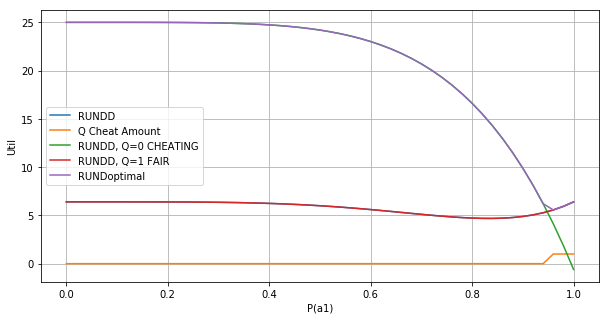

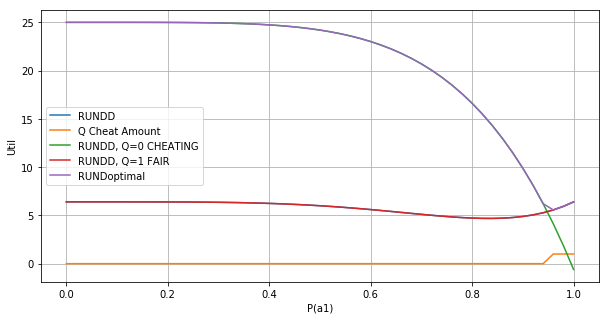

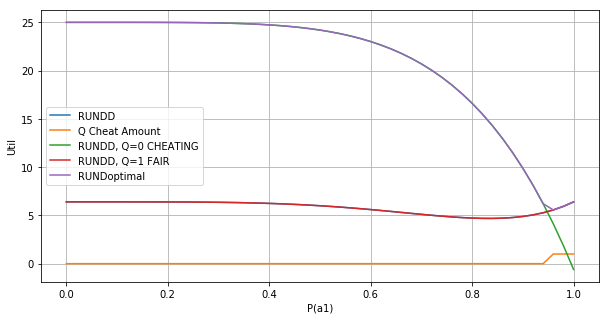

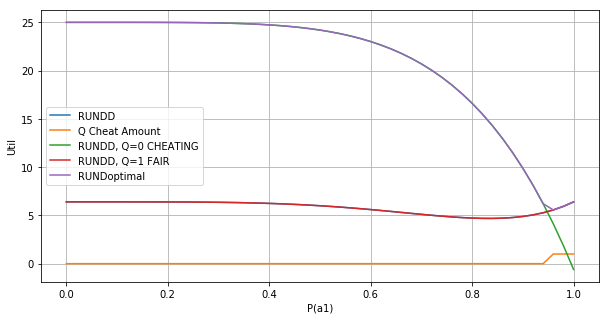

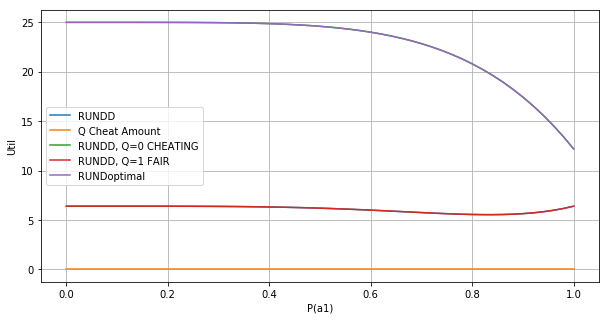

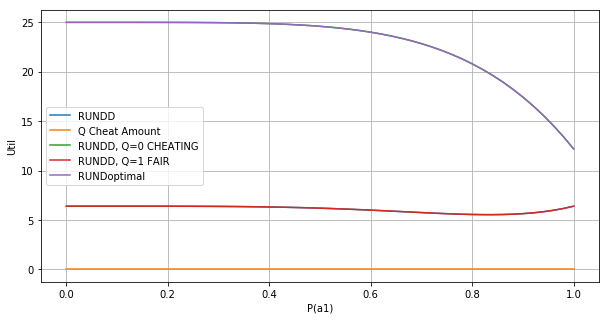

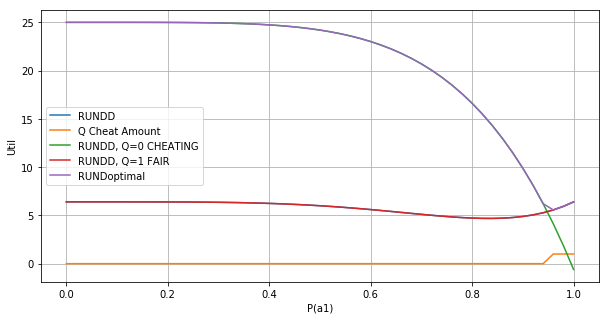

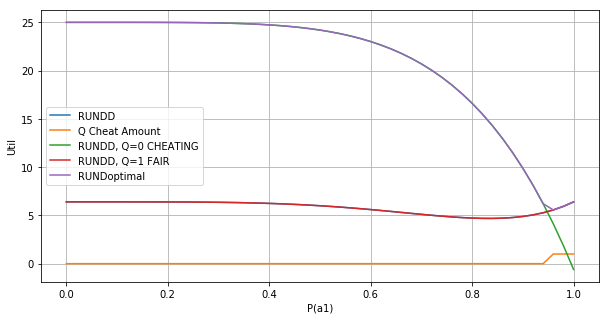

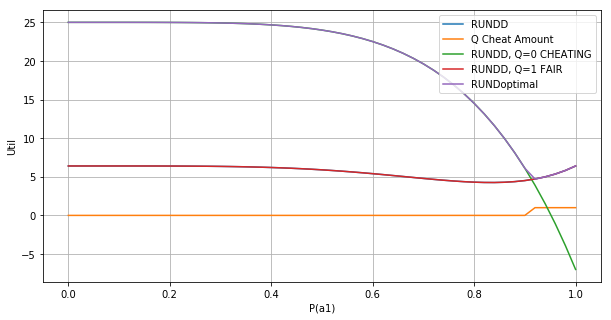

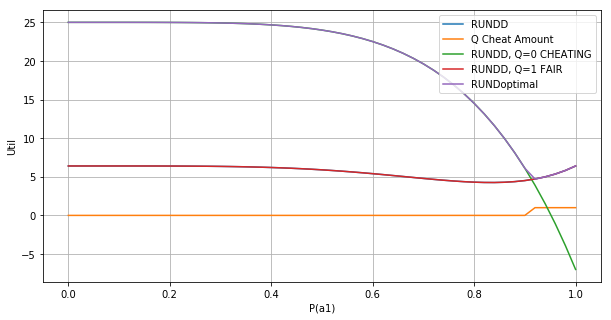

In [46]:
# ui = widgets.HBox([wn,wPR,wNDPR,wPrice,wp,wcj,wq,wroi,winsurance])
#wqTarget = widgets.FloatSlider(min=0,max=1,step=.01,value=1, description='Q Inflection Target',continuous_update=False)#Non-deterministic Penalty rate

ui1 = widgets.HBox([wn,wPR,wNDPR])
ui2 = widgets.HBox([wBenefit,wPrice,wp,wjcj])
ui3 = widgets.HBox([wrcj,wq,wroi,winsurance])
ui4 = widgets.HBox([wqTarget])

# interactive_plot = widgets.interactive(plot, M_n=wn,M_PR=wPR,M_NDPR=wNDPR,price=wPrice,p=wp,cj=wcj, q=wq,roi=wroi,Insurance=winsurance);
interactive_plotFinal = widgets.interactive_output(plotnonDetFINAL,{'M_n':wn,'M_PR':wPR,'M_NDPR':wNDPR,'price':wPrice,'b':wBenefit, 'qTarget':wqTarget, 'p':wp,'jcj':wjcj, 'q':wq,'roi':wroi,'Insurance':winsurance,'rcj':wrcj});
# output = interactive_plot.children[-1]

interactive_plotFinal.layout.height = '500'

display(interactive_plotFinal,ui1,ui2,ui3,ui4)
